In [6]:
import torch
import pandas as pd
import numpy as np
# 新数据
# 读取所有数据
paths = [
    # '../data/processed_data_900_1.csv', '../data/processed_data_900_2.csv', '../data/processed_data_900_3.csv',
    # '../data/processed_data_1050_1.csv', '../data/processed_data_1050_2.csv', '../data/processed_data_1050_3.csv',
    '../data/processed_data_1200_1.csv', '../data/processed_data_1200_2.csv', '../data/processed_data_1200_3.csv',
    # '../data/processed_data_1350_1.csv', '../data/processed_data_1350_2.csv', '../data/processed_data_1350_3.csv',
    # '../data/processed_data_1500_1.csv', '../data/processed_data_1500_2.csv', '../data/processed_data_1500_3.csv',
    # '../data/processed_data_1650_1.csv', '../data/processed_data_1650_2.csv', '../data/processed_data_1650_3.csv',
]

# 读取并拼接数据
# all_data = pd.concat([pd.read_csv(path) for path in paths], ignore_index=True)
# all_data = np.array(all_data)
# all_data.shape

In [7]:
all_data = []
for path in paths:
    data = pd.read_csv(path)
    data = np.array(data)
    all_data.append(data)
all_data = np.concatenate(all_data, axis=0)

In [8]:
all_data.shape

(1338, 1)

In [9]:
# 
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
import pandas as pd
# 设定随机种子以保证结果可复现
torch.manual_seed(0)
np.random.seed(0)

# 设定设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
all_data

array([['(Mo3O9,91);(Mo3O9S2,13);(MoO2,5);(MoOS,11);(MoO2,13);(MoO,40);(MoOS2,3);(MoO,1);(MoOS2,14);(MoS,2);(MoOS2,1);(MoS,1);(MoOS2,2);(MoS,1);(MoOS2,4);(MoS,1);(MoOS2,2);(MoS,1);(MoOS2,8);(MoS,1);(MoOS2,12);(MoS,1);(MoOS2,4);(MoS,2);(MoOS2,15);(MoS,1);(MoOS2,8);(MoS,1);(MoOS2,4);(MoS,2);(MoOS2,6);(MoS,1);(MoOS2,2);(MoS,1);(MoOS2,13);(MoS,3);(MoO2S,1);(MoOS,76);(MoOS3,2);(MoOS,7);(MoOS3,7);(MoOS,49);(MoOS3,19);(MoS2,101);(Mo2S7,3);(MoS3,1);(Mo2S7,57);(Mo2S5,1);(Mo2S7,118);(MoO,25);(MoOS,16);(MoS,9);(MoS2,52);(MoO,6);(MoOS2,4);(MoS,1);(MoOS2,9);(MoS,156);(MoS3,9);(MoS,1);(MoS3,57);(MoS,1);(MoS3,68);(MoOS4,1);(MoS3,52);(MoS5,27);(MoS3,187);(MoOS4,1);(MoS3,84);(MoS5,269);(MoOS6,3);(MoS5,1);(MoOS6,4);(MoS3,1);(MoS5,1);(MoOS6,10);(MoS5,1);(MoOS6,1);(MoS5,1);(MoOS6,2);(MoS5,1);(MoOS6,3);(MoS5,158);(MoS6,4);(MoS4,1);(MoS6,759);(MoOS7,1);(MoS6,743);(MoS8,38);(MoS6,539);(MoOS7,1);(MoS6,2);(MoOS7,15);(MoS6,2);(MoOS7,6);(MoS6,1);(MoOS7,101);(MoS6,3);(MoOS7,123);(MoS6,321);(MoS8,208);(MoS10,1);(M

In [10]:
# 处理数据的函数
def process_data(data):
    pro_data = []
    for record in data:
        # 每条记录是一个字符串，将其按分号分割
        elements = record[0].split(';')
        processed_data = []
        for element in elements:
            # print(element)
            # 去除括号并按逗号分割成元素和数字
            mol, count = element.strip('()').split(',')
            processed_data.append((mol, int(count)))
        pro_data.append(np.array(processed_data))
    return pro_data

# 调用函数处理数据
processed = process_data(all_data)
processed = np.array(processed)
print(processed.shape)

(1338,)


C:\Users\dfgje\AppData\Local\Temp\ipykernel_33556\2383512409.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  processed = np.array(processed)


In [6]:
processed[1]

array([['Mo3O9', '91'],
       ['Mo3O9S2', '13'],
       ['Mo2O4', '5'],
       ...,
       ['MoS5', '1'],
       ['MoOS6', '32'],
       ['MoS5', '1']], dtype='<U11')

In [11]:
import numpy as np
# 编码，转换成向量
def incode(molecule):
    vec = np.zeros(3)
    length = len(molecule)
    Mo = molecule.find('Mo')
    O = molecule.find('O')
    S = molecule.find('S')
    # print(Mo, O, S)
    moi = oi = si = 0
    moi = 1
    if O==-1 and S==-1 and length>2:
        moi = molecule[Mo+2:]
    elif O != -1:
        if O > Mo + 2:
            moi = int(molecule[Mo+2:O])
        else:
            moi = 1
        if S == O + 1 or O+1==length:
            oi = 1
        elif S==-1:
            oi = int(molecule[O+1:])
        else:
            oi = int(molecule[O+1:S])
    elif S != -1:
        if S > Mo + 2:
            moi = int(molecule[Mo+2:S])
        else:
            moi = 1
        if S+1==length:
            si = 1
        else:
            si = int(molecule[S+1:])
    if S!=-1:
        if S+1==length:
            si = 1
        else:
            si = int(molecule[S+1:])
    vec = np.array([moi, oi, si])
    return vec
incode('MoOS13')

array([ 1,  1, 13])

In [6]:
# 使用列表推导式遍历二维数组并调用函数进行编码，将返回值存储在新的二维数组中
# all_data = [[incode(value) for value in row] for row in cy_data]
# all_data = np.array(all_data)
# all_data.shape
cy_data = processed#.iloc[:, :2500]#.iloc[:, ::10]  # 对数据进行每隔10列重新采样
cy_data = np.array(cy_data)
# cy_data = [[incode(value[0]) for value in row] for row in cy_data]
cy_data = [[np.append(incode(value[0]), int(value[1])) for value in row] for row in cy_data]
# cy_data = np.concatenate(cy_data)
cy_data = np.array(cy_data)
cy_data.shape #(1726, 3000, 3)

C:\Users\dfgje\AppData\Local\Temp\ipykernel_16776\161354326.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cy_data = np.array(cy_data)


(1338,)

In [13]:
cy_data[0]

[array([ 3,  9,  0, 91]),
 array([ 3,  9,  2, 13]),
 array([1, 2, 0, 5]),
 array([ 1,  1,  1, 11]),
 array([ 1,  2,  0, 13]),
 array([ 1,  1,  0, 40]),
 array([1, 1, 2, 3]),
 array([1, 1, 0, 1]),
 array([ 1,  1,  2, 14]),
 array([1, 0, 1, 2]),
 array([1, 1, 2, 1]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 2]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 4]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 2]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 8]),
 array([1, 0, 1, 1]),
 array([ 1,  1,  2, 12]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 4]),
 array([1, 0, 1, 2]),
 array([ 1,  1,  2, 15]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 8]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 4]),
 array([1, 0, 1, 2]),
 array([1, 1, 2, 6]),
 array([1, 0, 1, 1]),
 array([1, 1, 2, 2]),
 array([1, 0, 1, 1]),
 array([ 1,  1,  2, 13]),
 array([1, 0, 1, 3]),
 array([1, 2, 1, 1]),
 array([ 1,  1,  1, 76]),
 array([1, 1, 3, 2]),
 array([1, 1, 1, 7]),
 array([1, 1, 3, 7]),
 array([ 1,  1,  1, 49]),
 array([ 1,  1,  3, 19]),
 array

In [7]:
import numpy as np
from tqdm import tqdm

# 构建数据集
def create_dataset(data, sequence_length):
    """
    将输入数据分割为长度为 sequence_length 的序列。
    """
    sequences = []
    for i in range(len(data) - sequence_length):
        # 构建序列
        sequences.append(data[i:i + sequence_length])
    return sequences

# 参数
sequence_length = 10

# 假设 cy_data 是 list，转换为合适的格式
# 如果 cy_data 是嵌套 list，则可以直接用它；否则，先检查数据格式
sequences = []
X = []
y = []
for row in cy_data:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    X.append(sequence[:-1])  # 除去最后一个序列
    y.append(sequence[1:, -1])  # 每个序列的最后一个时间步作为输出

sequences = np.array(sequences)
X = np.array(X)
y = np.array(y)
# 检查生成的序列形状
print('sequences.shape', sequences.shape)

# 构建输入 X 和输出 y

print('X.shape', X.shape)  # 输入的形状
print('y.shape', y.shape)  # 输出的形状


sequences.shape (1338,)
X.shape (1338,)
y.shape (1338,)


C:\Users\dfgje\AppData\Local\Temp\ipykernel_16776\1166615506.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sequences = np.array(sequences)
C:\Users\dfgje\AppData\Local\Temp\ipykernel_16776\1166615506.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
C:\Users\dfgje\AppData\Local\Temp\ipykernel_16776\1166615506.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you m

In [8]:
# 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print('X_train.shape', X_train.shape)# X_train.shape (1035, 2899, 100, 3)
print('X_test.shape', X_test.shape)# X_test.shape (691, 2899, 100, 3)
print('y_train.shape', y_train.shape)# y_train.shape (1035, 2899, 3)
print('y_test.shape', y_test.shape)# y_test.shape (691, 2899, 3)

X_train.shape (802,)
X_test.shape (536,)
y_train.shape (802,)
y_test.shape (536,)


In [86]:
X_train.shape

(394618, 10, 3)

In [9]:
X_train = np.concatenate(X_train)
X_train = X_train.reshape(-1, 10, 4)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
X_test = X_test.reshape(-1, 10, 4)
y_test = np.concatenate(y_test)
print('X_train.shape', X_train.shape)# X_train.shape (1035, 2899, 100, 3)
print('X_test.shape', X_test.shape)# X_test.shape (691, 2899, 100, 3)
print('y_train.shape', y_train.shape)# y_train.shape (1035, 2899, 3)
print('y_test.shape', y_test.shape)# y_test.shape (691, 2899, 3)

X_train.shape (394618, 10, 4)
X_test.shape (264803, 10, 4)
y_train.shape (394618, 4)
y_test.shape (264803, 4)


In [47]:
y_train = y_train[:, 3]
y_test = y_test[:, 3]
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train.shape, y_test.shape

((394618, 1), (264803, 1))

In [22]:
y_train.shape[-1]

394618

In [15]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 初始化scaler
scaler = MinMaxScaler()

# Reshape the data to 2D for fitting the scaler
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])  # (130657*10, 4)
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])    # (102104*10, 4)

# Fit the scaler on training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to original dimensions
X_train_normalized = X_train_scaled.reshape(X_train.shape)  # (130657, 10, 4)
X_test_normalized = X_test_scaled.reshape(X_test.shape)    # (102104, 10, 4)

y_train_reshaped = y_train.reshape(-1, y_train.shape[-1])  # (130657*10, 4)
y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])    # (102104*10, 4)

# # y_train_reshaped = y_train.reshape(-1, 1)  # (130657*10, 4)
# # y_test_reshaped = y_test.reshape(-1, 1)    # (102104*10, 4)

# Fit the scaler on training data and transform both train and test sets
y_train_scaled = scaler.fit_transform(y_train_reshaped)
y_test_scaled = scaler.transform(y_test_reshaped)

# Reshape back to original dimensions
y_train_normalized = y_train_scaled.reshape(y_train.shape)  # (130657, 10, 4)
y_test_normalized = y_test_scaled.reshape(y_test.shape)    # (102104, 10, 4)

X_train_normalized.shape, y_train_normalized.shape, X_test_normalized.shape, y_test_normalized.shape

((394618, 10, 4), (394618, 4), (264803, 10, 4), (264803, 4))

In [18]:
# train_data = TensorDataset(X_train, y_train)
# test_data = TensorDataset(X_test, y_test)
# train_data = TensorDataset(torch.tensor(X_train_normalized), torch.tensor(y_train))
train_data = TensorDataset(torch.tensor(X_train_normalized), torch.tensor(y_train_normalized))

# train_data = TensorDataset(torch.tensor(X_train_new), torch.tensor(y_train_new))
test_data = TensorDataset(torch.tensor(X_test_normalized), torch.tensor(y_test_normalized))
# test_data = TensorDataset(torch.tensor(X_test_normalized), torch.tensor(y_test))

train epoch 0: 100%|██████████| 1542/1542 [00:08<00:00, 182.56batch/s]


Epoch 1/100, Train Loss: 0.005455249636658998, Validation Loss: 0.002568643807322754 Current learning rate: 0.0001


train epoch 1: 100%|██████████| 1542/1542 [00:08<00:00, 186.80batch/s]


Epoch 2/100, Train Loss: 0.002663899066924204, Validation Loss: 0.002357991009932079 Current learning rate: 0.0001


train epoch 2: 100%|██████████| 1542/1542 [00:08<00:00, 187.82batch/s]


Epoch 3/100, Train Loss: 0.002512073757379802, Validation Loss: 0.0023877822832825283 Current learning rate: 0.0001


train epoch 3: 100%|██████████| 1542/1542 [00:07<00:00, 194.12batch/s]


Epoch 4/100, Train Loss: 0.002330699708481409, Validation Loss: 0.0022197691935023456 Current learning rate: 0.0001


train epoch 4: 100%|██████████| 1542/1542 [00:08<00:00, 187.52batch/s]


Epoch 5/100, Train Loss: 0.002218528440078116, Validation Loss: 0.0021360162847055626 Current learning rate: 0.0001


train epoch 5: 100%|██████████| 1542/1542 [00:08<00:00, 190.23batch/s]


Epoch 6/100, Train Loss: 0.002152512567353642, Validation Loss: 0.0020815329086024243 Current learning rate: 0.0001


train epoch 6: 100%|██████████| 1542/1542 [00:08<00:00, 190.80batch/s]


Epoch 7/100, Train Loss: 0.0021011117288252264, Validation Loss: 0.001992185548175512 Current learning rate: 0.0001


train epoch 7: 100%|██████████| 1542/1542 [00:08<00:00, 189.80batch/s]


Epoch 8/100, Train Loss: 0.0020601799825966686, Validation Loss: 0.0019590849375611245 Current learning rate: 0.0001


train epoch 8: 100%|██████████| 1542/1542 [00:08<00:00, 190.85batch/s]


Epoch 9/100, Train Loss: 0.002023669399555958, Validation Loss: 0.001932562537477121 Current learning rate: 0.0001


train epoch 9: 100%|██████████| 1542/1542 [00:08<00:00, 189.76batch/s]


Epoch 10/100, Train Loss: 0.0020007180953796025, Validation Loss: 0.0019081704053829692 Current learning rate: 0.0001


train epoch 10: 100%|██████████| 1542/1542 [00:08<00:00, 190.31batch/s]


Epoch 11/100, Train Loss: 0.0019799080845835917, Validation Loss: 0.0018839079273332744 Current learning rate: 0.0001


train epoch 11: 100%|██████████| 1542/1542 [00:07<00:00, 193.38batch/s]


Epoch 12/100, Train Loss: 0.001962483447683003, Validation Loss: 0.0018719681320854818 Current learning rate: 0.0001


train epoch 12: 100%|██████████| 1542/1542 [00:08<00:00, 191.88batch/s]


Epoch 13/100, Train Loss: 0.0019369771995144337, Validation Loss: 0.001855351618901449 Current learning rate: 0.0001


train epoch 13: 100%|██████████| 1542/1542 [00:08<00:00, 191.56batch/s]


Epoch 14/100, Train Loss: 0.0019171449928894859, Validation Loss: 0.0018357943100889553 Current learning rate: 0.0001


train epoch 14: 100%|██████████| 1542/1542 [00:08<00:00, 190.68batch/s]


Epoch 15/100, Train Loss: 0.0018853667690738765, Validation Loss: 0.0018152701776130741 Current learning rate: 0.0001


train epoch 15: 100%|██████████| 1542/1542 [00:08<00:00, 190.27batch/s]


Epoch 16/100, Train Loss: 0.0018667176080603676, Validation Loss: 0.0017960452884172382 Current learning rate: 0.0001


train epoch 16: 100%|██████████| 1542/1542 [00:07<00:00, 193.78batch/s]


Epoch 17/100, Train Loss: 0.001844199339423489, Validation Loss: 0.0017725378124622505 Current learning rate: 0.0001


train epoch 17: 100%|██████████| 1542/1542 [00:08<00:00, 191.35batch/s]


Epoch 18/100, Train Loss: 0.001830004289841155, Validation Loss: 0.001766913670560799 Current learning rate: 0.0001


train epoch 18: 100%|██████████| 1542/1542 [00:08<00:00, 188.49batch/s]


Epoch 19/100, Train Loss: 0.0018134869558780716, Validation Loss: 0.0017579540538608326 Current learning rate: 0.0001


train epoch 19: 100%|██████████| 1542/1542 [00:08<00:00, 189.85batch/s]


Epoch 20/100, Train Loss: 0.001800065366731905, Validation Loss: 0.001749985187272201 Current learning rate: 0.0001


train epoch 20: 100%|██████████| 1542/1542 [00:07<00:00, 193.07batch/s]


Epoch 21/100, Train Loss: 0.0017901092166991255, Validation Loss: 0.0017431771605977016 Current learning rate: 0.0001


train epoch 21: 100%|██████████| 1542/1542 [00:08<00:00, 191.78batch/s]


Epoch 22/100, Train Loss: 0.0017792037237824782, Validation Loss: 0.0017313011419435426 Current learning rate: 0.0001


train epoch 22: 100%|██████████| 1542/1542 [00:08<00:00, 190.27batch/s]


Epoch 23/100, Train Loss: 0.0017699909400536956, Validation Loss: 0.0017330385325931715 Current learning rate: 0.0001


train epoch 23: 100%|██████████| 1542/1542 [00:07<00:00, 195.25batch/s]


Epoch 24/100, Train Loss: 0.0017622324450981724, Validation Loss: 0.0017263530906084402 Current learning rate: 0.0001


train epoch 24: 100%|██████████| 1542/1542 [00:07<00:00, 194.76batch/s]


Epoch 25/100, Train Loss: 0.0017558152611950443, Validation Loss: 0.0017252862610684647 Current learning rate: 0.0001


train epoch 25: 100%|██████████| 1542/1542 [00:07<00:00, 196.36batch/s]


Epoch 26/100, Train Loss: 0.0017517193524072213, Validation Loss: 0.001722427862951711 Current learning rate: 0.0001


train epoch 26: 100%|██████████| 1542/1542 [00:07<00:00, 194.98batch/s]


Epoch 27/100, Train Loss: 0.0017404609237186537, Validation Loss: 0.001713433536162378 Current learning rate: 0.0001


train epoch 27: 100%|██████████| 1542/1542 [00:07<00:00, 195.24batch/s]


Epoch 28/100, Train Loss: 0.001735710638759363, Validation Loss: 0.0017110341070670492 Current learning rate: 0.0001


train epoch 28: 100%|██████████| 1542/1542 [00:07<00:00, 193.80batch/s]


Epoch 29/100, Train Loss: 0.0017272110526126354, Validation Loss: 0.001704829225928 Current learning rate: 0.0001


train epoch 29: 100%|██████████| 1542/1542 [00:07<00:00, 197.00batch/s]


Epoch 30/100, Train Loss: 0.0017154123949650974, Validation Loss: 0.0016923206890946923 Current learning rate: 0.0001


train epoch 30: 100%|██████████| 1542/1542 [00:07<00:00, 195.25batch/s]


Epoch 31/100, Train Loss: 0.001703415756377517, Validation Loss: 0.0016805843339381577 Current learning rate: 0.0001


train epoch 31: 100%|██████████| 1542/1542 [00:07<00:00, 193.88batch/s]


Epoch 32/100, Train Loss: 0.0016968766534179215, Validation Loss: 0.0016751446627622586 Current learning rate: 0.0001


train epoch 32: 100%|██████████| 1542/1542 [00:07<00:00, 194.74batch/s]


Epoch 33/100, Train Loss: 0.0016895850268013473, Validation Loss: 0.0016701773668136442 Current learning rate: 0.0001


train epoch 33: 100%|██████████| 1542/1542 [00:07<00:00, 193.04batch/s]


Epoch 34/100, Train Loss: 0.0016781547576329397, Validation Loss: 0.0016690153339948375 Current learning rate: 0.0001


train epoch 34: 100%|██████████| 1542/1542 [00:07<00:00, 194.43batch/s]


Epoch 35/100, Train Loss: 0.0016721024663519531, Validation Loss: 0.0016660553988807859 Current learning rate: 0.0001


train epoch 35: 100%|██████████| 1542/1542 [00:07<00:00, 195.15batch/s]


Epoch 36/100, Train Loss: 0.0016654971443783551, Validation Loss: 0.0016627278270960602 Current learning rate: 0.0001


train epoch 36: 100%|██████████| 1542/1542 [00:07<00:00, 195.95batch/s]


Epoch 37/100, Train Loss: 0.001656876493426611, Validation Loss: 0.0016542327257719229 Current learning rate: 0.0001


train epoch 37: 100%|██████████| 1542/1542 [00:07<00:00, 196.39batch/s]


Epoch 38/100, Train Loss: 0.0016549585085210373, Validation Loss: 0.0016499659494880856 Current learning rate: 0.0001


train epoch 38: 100%|██████████| 1542/1542 [00:07<00:00, 194.85batch/s]


Epoch 39/100, Train Loss: 0.0016479845042968021, Validation Loss: 0.0016493988924985343 Current learning rate: 0.0001


train epoch 39: 100%|██████████| 1542/1542 [00:08<00:00, 191.72batch/s]


Epoch 40/100, Train Loss: 0.0016439764947657237, Validation Loss: 0.0016485672958870363 Current learning rate: 0.0001


train epoch 40: 100%|██████████| 1542/1542 [00:08<00:00, 192.26batch/s]


Epoch 41/100, Train Loss: 0.001636270209837204, Validation Loss: 0.0016435108508881387 Current learning rate: 0.0001


train epoch 41: 100%|██████████| 1542/1542 [00:07<00:00, 193.22batch/s]


Epoch 42/100, Train Loss: 0.0016291922965398626, Validation Loss: 0.0016472848292754343 Current learning rate: 0.0001


train epoch 42: 100%|██████████| 1542/1542 [00:07<00:00, 194.32batch/s]


Epoch 43/100, Train Loss: 0.0016252586856748622, Validation Loss: 0.0016545567431966478 Current learning rate: 0.0001


train epoch 43: 100%|██████████| 1542/1542 [00:08<00:00, 190.06batch/s]


Epoch 44/100, Train Loss: 0.00161936620200755, Validation Loss: 0.001661117067848077 Current learning rate: 0.0001


train epoch 44: 100%|██████████| 1542/1542 [00:08<00:00, 191.02batch/s]


Epoch 45/100, Train Loss: 0.0016156231112681154, Validation Loss: 0.001658563790545965 Current learning rate: 0.0001


train epoch 45: 100%|██████████| 1542/1542 [00:08<00:00, 191.79batch/s]


Epoch 46/100, Train Loss: 0.0016087506475456505, Validation Loss: 0.0016783542256885063 Current learning rate: 0.0001


train epoch 46: 100%|██████████| 1542/1542 [00:08<00:00, 191.28batch/s]


Epoch 47/100, Train Loss: 0.0016080881700583842, Validation Loss: 0.0016798717148725664 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


train epoch 47: 100%|██████████| 1542/1542 [00:07<00:00, 193.02batch/s]


Epoch 48/100, Train Loss: 0.0016019787254780025, Validation Loss: 0.0016676399878598526 Current learning rate: 0.0001


train epoch 48: 100%|██████████| 1542/1542 [00:08<00:00, 191.98batch/s]


Epoch 49/100, Train Loss: 0.001600176118081766, Validation Loss: 0.0016669855203749406 Current learning rate: 0.0001


train epoch 49: 100%|██████████| 1542/1542 [00:07<00:00, 193.67batch/s]


Epoch 50/100, Train Loss: 0.0015963433818539897, Validation Loss: 0.0016556787451900779 Current learning rate: 0.0001


train epoch 50: 100%|██████████| 1542/1542 [00:07<00:00, 192.96batch/s]


Epoch 51/100, Train Loss: 0.0015917589260292003, Validation Loss: 0.0016576486064209986 Current learning rate: 0.0001


train epoch 51: 100%|██████████| 1542/1542 [00:08<00:00, 191.18batch/s]


Epoch 52/100, Train Loss: 0.0015912108550341483, Validation Loss: 0.0016611179217546383 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


train epoch 52: 100%|██████████| 1542/1542 [00:08<00:00, 189.82batch/s]


Epoch 53/100, Train Loss: 0.0015851665949470366, Validation Loss: 0.0016491912114145893 Current learning rate: 0.0001


train epoch 53: 100%|██████████| 1542/1542 [00:08<00:00, 191.98batch/s]


Epoch 54/100, Train Loss: 0.0015836539339668702, Validation Loss: 0.001653254192109416 Current learning rate: 0.0001


train epoch 54: 100%|██████████| 1542/1542 [00:08<00:00, 192.71batch/s]


Epoch 55/100, Train Loss: 0.0015809771515930815, Validation Loss: 0.001649833416131031 Current learning rate: 0.0001


train epoch 55: 100%|██████████| 1542/1542 [00:08<00:00, 191.23batch/s]


Epoch 56/100, Train Loss: 0.0015765030051254814, Validation Loss: 0.0016451057988413832 Current learning rate: 0.0001


train epoch 56: 100%|██████████| 1542/1542 [00:08<00:00, 189.07batch/s]


Epoch 57/100, Train Loss: 0.0015729072267799508, Validation Loss: 0.0016377491558897958 Current learning rate: 0.0001


train epoch 57: 100%|██████████| 1542/1542 [00:08<00:00, 192.47batch/s]


Epoch 58/100, Train Loss: 0.0015711557809290645, Validation Loss: 0.0016409899547261595 Current learning rate: 0.0001


train epoch 58: 100%|██████████| 1542/1542 [00:07<00:00, 192.90batch/s]


Epoch 59/100, Train Loss: 0.0015678969699163836, Validation Loss: 0.0016380197458694464 Current learning rate: 0.0001


train epoch 59: 100%|██████████| 1542/1542 [00:08<00:00, 192.54batch/s]


Epoch 60/100, Train Loss: 0.0015626186630036225, Validation Loss: 0.0016297921208593034 Current learning rate: 0.0001


train epoch 60: 100%|██████████| 1542/1542 [00:08<00:00, 191.90batch/s]


Epoch 61/100, Train Loss: 0.0015598472496448361, Validation Loss: 0.0016337833197687121 Current learning rate: 0.0001


train epoch 61: 100%|██████████| 1542/1542 [00:08<00:00, 190.38batch/s]


Epoch 62/100, Train Loss: 0.0015573536224801547, Validation Loss: 0.0016319731394795285 Current learning rate: 0.0001


train epoch 62: 100%|██████████| 1542/1542 [00:08<00:00, 190.24batch/s]


Epoch 63/100, Train Loss: 0.0015590168079299932, Validation Loss: 0.0016287202178700945 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


train epoch 63: 100%|██████████| 1542/1542 [00:08<00:00, 189.04batch/s]


Epoch 64/100, Train Loss: 0.0015500816667553137, Validation Loss: 0.0016287210855869155 Current learning rate: 0.0001


train epoch 64: 100%|██████████| 1542/1542 [00:08<00:00, 191.46batch/s]


Epoch 65/100, Train Loss: 0.0015480076757652588, Validation Loss: 0.0016252028403732986 Current learning rate: 0.0001


train epoch 65: 100%|██████████| 1542/1542 [00:07<00:00, 193.22batch/s]


Epoch 66/100, Train Loss: 0.00154545819958058, Validation Loss: 0.0016244206798085319 Current learning rate: 0.0001


train epoch 66: 100%|██████████| 1542/1542 [00:08<00:00, 191.85batch/s]


Epoch 67/100, Train Loss: 0.0015422982606561552, Validation Loss: 0.001625705085153522 Current learning rate: 0.0001


train epoch 67: 100%|██████████| 1542/1542 [00:08<00:00, 189.77batch/s]


Epoch 68/100, Train Loss: 0.0015385675084869405, Validation Loss: 0.0016247173193772576 Current learning rate: 0.0001


train epoch 68: 100%|██████████| 1542/1542 [00:08<00:00, 190.95batch/s]


Epoch 69/100, Train Loss: 0.0015347358470123565, Validation Loss: 0.001621475502658589 Current learning rate: 0.0001


train epoch 69: 100%|██████████| 1542/1542 [00:07<00:00, 194.16batch/s]


Epoch 70/100, Train Loss: 0.0015358224623324046, Validation Loss: 0.0016124184882391121 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


train epoch 70: 100%|██████████| 1542/1542 [00:07<00:00, 194.36batch/s]


Epoch 71/100, Train Loss: 0.0015302207001405155, Validation Loss: 0.0016227071601905036 Current learning rate: 0.0001


train epoch 71: 100%|██████████| 1542/1542 [00:07<00:00, 195.56batch/s]


Epoch 72/100, Train Loss: 0.0015293835820412338, Validation Loss: 0.0016223356959737677 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


train epoch 72: 100%|██████████| 1542/1542 [00:08<00:00, 192.11batch/s]


Epoch 73/100, Train Loss: 0.0015235321841420846, Validation Loss: 0.001622287734911712 Current learning rate: 0.0001


train epoch 73: 100%|██████████| 1542/1542 [00:07<00:00, 193.63batch/s]


Epoch 74/100, Train Loss: 0.001523513543920182, Validation Loss: 0.0016204340251314037 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


train epoch 74: 100%|██████████| 1542/1542 [00:08<00:00, 192.56batch/s]


Epoch 75/100, Train Loss: 0.0015186952090559037, Validation Loss: 0.001618031663807142 Current learning rate: 0.0001


train epoch 75: 100%|██████████| 1542/1542 [00:07<00:00, 193.13batch/s]


Epoch 76/100, Train Loss: 0.0015168811410768224, Validation Loss: 0.0016258177898296725 Current learning rate: 0.0001


train epoch 76: 100%|██████████| 1542/1542 [00:07<00:00, 193.82batch/s]


Epoch 77/100, Train Loss: 0.0015131706213583514, Validation Loss: 0.0016189037951365951 Current learning rate: 0.0001


train epoch 77: 100%|██████████| 1542/1542 [00:07<00:00, 192.97batch/s]


Epoch 78/100, Train Loss: 0.0015111943778468898, Validation Loss: 0.0016224528516225244 Current learning rate: 0.0001


train epoch 78: 100%|██████████| 1542/1542 [00:08<00:00, 190.88batch/s]


Epoch 79/100, Train Loss: 0.001508549207484395, Validation Loss: 0.0016175906653658702 Current learning rate: 0.0001


train epoch 79: 100%|██████████| 1542/1542 [00:08<00:00, 190.33batch/s]


Epoch 80/100, Train Loss: 0.001504622417940543, Validation Loss: 0.0016180282032254964 Current learning rate: 0.0001


train epoch 80: 100%|██████████| 1542/1542 [00:08<00:00, 191.80batch/s]


Epoch 81/100, Train Loss: 0.001502985358035076, Validation Loss: 0.0016213373605650204 Current learning rate: 0.0001


train epoch 81: 100%|██████████| 1542/1542 [00:07<00:00, 195.34batch/s]


Epoch 82/100, Train Loss: 0.0015002389023262466, Validation Loss: 0.0016290301389200036 Current learning rate: 0.0001


train epoch 82: 100%|██████████| 1542/1542 [00:08<00:00, 191.38batch/s]


Epoch 83/100, Train Loss: 0.0014956627595752849, Validation Loss: 0.0016224474435051633 Current learning rate: 0.0001


train epoch 83: 100%|██████████| 1542/1542 [00:07<00:00, 194.10batch/s]


Epoch 84/100, Train Loss: 0.0014921790120191796, Validation Loss: 0.0016183466193302627 Current learning rate: 0.0001


train epoch 84: 100%|██████████| 1542/1542 [00:07<00:00, 192.91batch/s]


Epoch 85/100, Train Loss: 0.0014913790192857147, Validation Loss: 0.0016196894462106556 Current learning rate: 0.0001
EarlyStopping counter: 7 out of 20


train epoch 85: 100%|██████████| 1542/1542 [00:07<00:00, 192.90batch/s]


Epoch 86/100, Train Loss: 0.0014860754975642547, Validation Loss: 0.0016176740410914145 Current learning rate: 0.0001


train epoch 86: 100%|██████████| 1542/1542 [00:07<00:00, 196.24batch/s]


Epoch 87/100, Train Loss: 0.0014835861417081418, Validation Loss: 0.0016253174314174717 Current learning rate: 0.0001


train epoch 87: 100%|██████████| 1542/1542 [00:08<00:00, 192.58batch/s]


Epoch 88/100, Train Loss: 0.0014826622473760604, Validation Loss: 0.0016123560840422277 Current learning rate: 0.0001
EarlyStopping counter: 8 out of 20


train epoch 88: 100%|██████████| 1542/1542 [00:07<00:00, 193.09batch/s]


Epoch 89/100, Train Loss: 0.0014772545512989356, Validation Loss: 0.0016189929136669599 Current learning rate: 0.0001


train epoch 89: 100%|██████████| 1542/1542 [00:08<00:00, 191.30batch/s]


Epoch 90/100, Train Loss: 0.0014765135008191206, Validation Loss: 0.0016153650514427237 Current learning rate: 0.0001
EarlyStopping counter: 9 out of 20


train epoch 90: 100%|██████████| 1542/1542 [00:08<00:00, 191.25batch/s]


Epoch 91/100, Train Loss: 0.0014706353941464922, Validation Loss: 0.0016297365188115186 Current learning rate: 0.0001


train epoch 91: 100%|██████████| 1542/1542 [00:08<00:00, 190.90batch/s]


Epoch 92/100, Train Loss: 0.001467260991224664, Validation Loss: 0.0016302518992216098 Current learning rate: 0.0001


train epoch 92: 100%|██████████| 1542/1542 [00:07<00:00, 193.72batch/s]


Epoch 93/100, Train Loss: 0.0014625512853364616, Validation Loss: 0.0016343477183759887 Current learning rate: 0.0001


train epoch 93: 100%|██████████| 1542/1542 [00:07<00:00, 193.79batch/s]


Epoch 94/100, Train Loss: 0.0014586913340760691, Validation Loss: 0.0016299625872047705 Current learning rate: 0.0001


train epoch 94: 100%|██████████| 1542/1542 [00:07<00:00, 193.49batch/s]


Epoch 95/100, Train Loss: 0.0014566506473283939, Validation Loss: 0.0016472519228502656 Current learning rate: 0.0001


train epoch 95: 100%|██████████| 1542/1542 [00:07<00:00, 192.92batch/s]


Epoch 96/100, Train Loss: 0.0014513000605486967, Validation Loss: 0.0016477779350952476 Current learning rate: 0.0001


train epoch 96: 100%|██████████| 1542/1542 [00:08<00:00, 192.69batch/s]


Epoch 97/100, Train Loss: 0.0014476311294339447, Validation Loss: 0.001624831639289197 Current learning rate: 0.0001


train epoch 97: 100%|██████████| 1542/1542 [00:08<00:00, 191.76batch/s]


Epoch 98/100, Train Loss: 0.0014464546693645256, Validation Loss: 0.0016313677720225992 Current learning rate: 0.0001


train epoch 98: 100%|██████████| 1542/1542 [00:08<00:00, 191.94batch/s]


Epoch 99/100, Train Loss: 0.0014394429149678337, Validation Loss: 0.0016531867824552764 Current learning rate: 0.0001


train epoch 99: 100%|██████████| 1542/1542 [00:07<00:00, 194.88batch/s]


Epoch 100/100, Train Loss: 0.0014373610883184815, Validation Loss: 0.0016309120075609404 Current learning rate: 0.0001


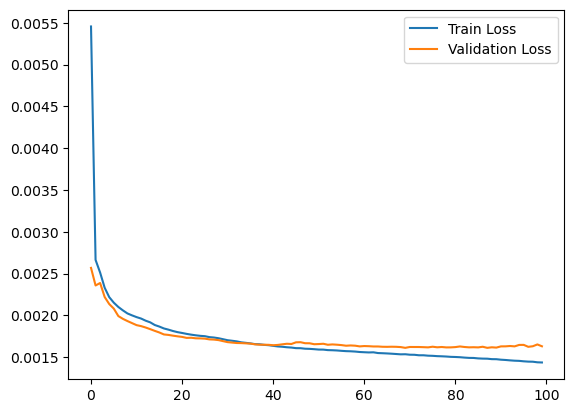

Epoch 100/100, Train Loss: 0.0014373610883184815, Validation Loss: 0.0016309120075609404
Test RMSE: 0.040375907
CPU times: total: 49.2 s
Wall time: 17min 35s


In [19]:
%%time
from torch.nn.parallel import DataParallel
import torch.nn.functional as F

hidden_size = 256
num_layers = 2
batch_size = 256
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
 
# LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.5):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Decode the hidden state of the last time step
        out = self.dropout(out[:, -1, :])  # Apply dropout before the fully connected layer
        out = self.fc(out)
        return out
    
# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(LSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_classes)
#         self.softmax = nn.Softmax(dim=1)  # Use softmax for multi-class classification

#     def forward(self, x):
#         # Initialize hidden state with zeros
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         # Initialize cell state
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         # Forward propagate LSTM
#         out, _ = self.lstm(x, (h0, c0))
#         # Decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :])
#         # Apply softmax to the output layer
#         out = self.softmax(out)
#         return out
    
# LSTM_SelfAttention model
class SelfAttention(nn.Module):
    def __init__(self, hidden_size):
        super(SelfAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attention_weights = nn.Parameter(torch.rand(hidden_size, 1))

    def forward(self, lstm_output):
        # lstm_output的形状是(batch_size, seq_len, hidden_size)
        attention_scores = torch.matmul(lstm_output, self.attention_weights)
        # attention_scores的形状是(batch_size, seq_len, 1)
        attention_scores = F.softmax(attention_scores, dim=1)
        # 使用attention_scores对lstm_output进行加权求和
        weighted_output = lstm_output * attention_scores
        output = torch.sum(weighted_output, dim=1)
        # output的形状是(batch_size, hidden_size)
        return output
    
# LSTM_SelfAttention model
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(LSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = SelfAttention(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        # 使用自注意力机制处理LSTM的输出
        attn_out = self.attention(lstm_out)
        # 应用 Dropout
        drop_out = self.dropout(attn_out)
        out = self.fc(drop_out)
        return out

# BiLSTM-MAIN model
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        self.attention_heads = nn.Parameter(torch.Tensor(num_heads, self.head_dim, 1))
        nn.init.xavier_uniform_(self.attention_heads)
        
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, lstm_output):
        batch_size, seq_len, hidden_size = lstm_output.size(0), lstm_output.size(1), lstm_output.size(2)
        # Reshape lstm_output to (batch_size, seq_len, num_heads, head_dim)
        lstm_output = lstm_output.view(batch_size, seq_len, self.num_heads, self.head_dim)
        # Transpose for matrix multiplication: (batch_size, num_heads, seq_len, head_dim)
        lstm_output = lstm_output.transpose(1, 2)
        # Compute attention scores
        attention_scores = torch.matmul(lstm_output, self.attention_heads)
        # Apply softmax to get the weights on the values
        attention_scores = F.softmax(attention_scores, dim=-2)
        # Apply attention weights to lstm_output
        weighted_output = attention_scores * lstm_output
        # Sum weighted output over seq_len dimension
        weighted_output = weighted_output.sum(dim=-2)
        # Reshape weighted_output to (batch_size, hidden_size)
        weighted_output = weighted_output.reshape(batch_size, -1)
        # Pass through the fully connected layer
        output = self.fc(weighted_output)
        return output

# BiLSTM-MAIN model
class LSTMWithMulAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate, num_heads):
        super(LSTMWithMulAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = MultiHeadSelfAttention(hidden_size*2, num_heads)  # 注意hidden_size*2因为BiLSTM
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        # 添加残差连接的线性层
        self.residual_fc = nn.Linear(hidden_size*2, hidden_size*2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # 乘以2因为BiLSTM
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        # 添加残差连接
        residual_output = lstm_out + self.residual_fc(lstm_out)
        lstm_out = self.layer_norm(residual_output)
        attn_out = self.attention(lstm_out)
        drop_out = self.dropout(attn_out)
        out = self.fc(drop_out)
        return out

# print('X_train.shape[-1]:',X_train.shape[-1])

input_size = 4
num_classes= 4
# model = LSTM(input_size, hidden_size, num_layers, num_classes, dropout_prob=0)
#model = LSTMWithAttention(input_size, hidden_size, num_layers, num_classes, dropout_rate = 0.2)
model = LSTMWithMulAttention(input_size, hidden_size, num_layers, num_classes, dropout_rate=0.1, num_heads=8)
# print('num_classes:', num_classes)
model = model.to(device)
model = nn.DataParallel(model)
criterion = nn.MSELoss() #nn.CrossEntropyLoss() #nn.MSELoss() #custom_loss 
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min',factor=0.5, patience=3, min_lr=1e-6, verbose=True)

# 训练模型
num_epochs = 100
best_loss = np.inf
early_stopping_patience = 20
early_stopping_counter = 0
loss_values = []

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for i, (x_batch, y_batch) in enumerate(tqdm(train_loader, desc=f"train epoch {epoch}" ,unit="batch")): #tqdm(train_loader, desc=f"train epoch {epoch}" ,unit="batch"))
        # one_batch_bar.set_description(f'[ epoch: {ep+1} ]')
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
#         print('x_batch:', x_batch.shape)
#         print('y_batch:', y_batch.shape)
        
        optimizer.zero_grad()
        # print('x_batch shape:',x_batch.shape[0])
        # print(x_batch.shape)
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, num_classes)
        
        outputs = model(x_batch)
        # print('outputs:', outputs.shape)
        loss = criterion(outputs, y_batch) #, x_batch
        loss.backward()
        optimizer.step()
        # break
        train_losses.append(loss.item())
        # 更新进度条后缀信息，显示当前损失值
        # tqdm.set_postfix({'loss': loss / (100 * (epoch+1))}, refresh=True)
    
    val_losses = []
    model.eval()
    with torch.no_grad():
        # for i, (x_batch, y_batch) in enumerate(test_loader):
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).float()
            
            x_batch = x_batch.view(-1, sequence_length, input_size)
            y_batch = y_batch.view(-1, num_classes)
            # y_batch = y_batch.squeeze().long()
            
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch) #, x_batch
            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    scheduler.step(train_loss)
    loss_values.append([train_loss, val_loss])

    # if epoch%10==0 :
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}', "Current learning rate:", scheduler.get_last_lr()[0])
    # 在每个 epoch 结束时获取最后设置的学习率并打印

    if train_loss - best_loss < -0.000001:
        # early_stopping_counter = 0
        best_loss = train_loss
        best_model = deepcopy(model.state_dict())
    else:
        early_stopping_counter += 1
        print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}')
        if early_stopping_counter >= early_stopping_patience:
            model.load_state_dict(best_model)
            print('Early stopping')
            break

# 保存最好的模型
torch.save(best_model, '../model/mul_T900_stst2.pth')#########################################################

# 画出loss变化曲线
loss_values = np.array(loss_values)
plt.plot(loss_values[:, 0], label='Train Loss')
plt.plot(loss_values[:, 1], label='Validation Loss')
plt.legend()
plt.show()

# 评估预测结果
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, num_classes)
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())
        targets.append(y_batch.cpu().numpy()) 

predictions = np.concatenate(predictions)
targets = np.concatenate(targets) 
print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
print('Test RMSE:', np.sqrt(mean_squared_error(targets, predictions)))

In [127]:
# 评估预测结果
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, input_size)
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())
        targets.append(y_batch.cpu().numpy()) 

predictions = np.concatenate(predictions)
targets = np.concatenate(targets) 

In [40]:
# 数据转回原始尺度
predictions = scaler.inverse_transform(predictions)
targets = scaler.inverse_transform(targets)


In [92]:
predictions.shape, targets.shape

((264803, 3), (264803, 3))

In [57]:
predictions_s = predictions
targets_s = targets
predictions = predictions[:, :-1]
targets = targets[:, :-1]

predictions.shape, targets.shape

((264803, 3), (264803, 3))

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 四舍五入的
# pre_round = np.round(new_pred)
print('Test RMSE:', np.sqrt(mean_squared_error(targets, predictions)))
# 计算均方误差（MSE）
mse = mean_squared_error(targets, predictions)
print("Mean Squared Error (MSE):", mse)

# 计算平均绝对误差（MAE）
mae = mean_absolute_error(targets, predictions)
print("Mean Absolute Error (MAE):", mae)

# 计算R平方
r2 = r2_score(targets, predictions)
print("R^2 Score:", r2)

Test RMSE: 0.016535016
Mean Squared Error (MSE): 0.00027340674
Mean Absolute Error (MAE): 0.0043009487
R^2 Score: 0.09223962376501194


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 四舍五入的
# pre_round = np.round(new_pred)
print('Test RMSE:', np.sqrt(mean_squared_error(targets, predictions)))
# 计算均方误差（MSE）
mse = mean_squared_error(targets, predictions)
print("Mean Squared Error (MSE):", mse)

# 计算平均绝对误差（MAE）
mae = mean_absolute_error(targets, predictions)
print("Mean Absolute Error (MAE):", mae)

# 计算R平方
r2 = r2_score(targets, predictions)
print("R^2 Score:", r2)

In [94]:
#保存预测结果
np.savez('../results/mul_T900_ss.npz', arr1=targets, arr2=predictions)

In [141]:
predictions[100], targets[100], predictions.shape, targets.shape

(array([1.0047483e+00, 4.1949246e-03, 5.0357013e+00, 2.4206024e+01],
       dtype=float32),
 array([1.        , 0.        , 5.        , 0.99999994], dtype=float32),
 (102104, 4),
 (102104, 4))

In [145]:
y_test[0]

array([1, 0, 1, 1])

IndexError: index 1 is out of bounds for axis 1 with size 1

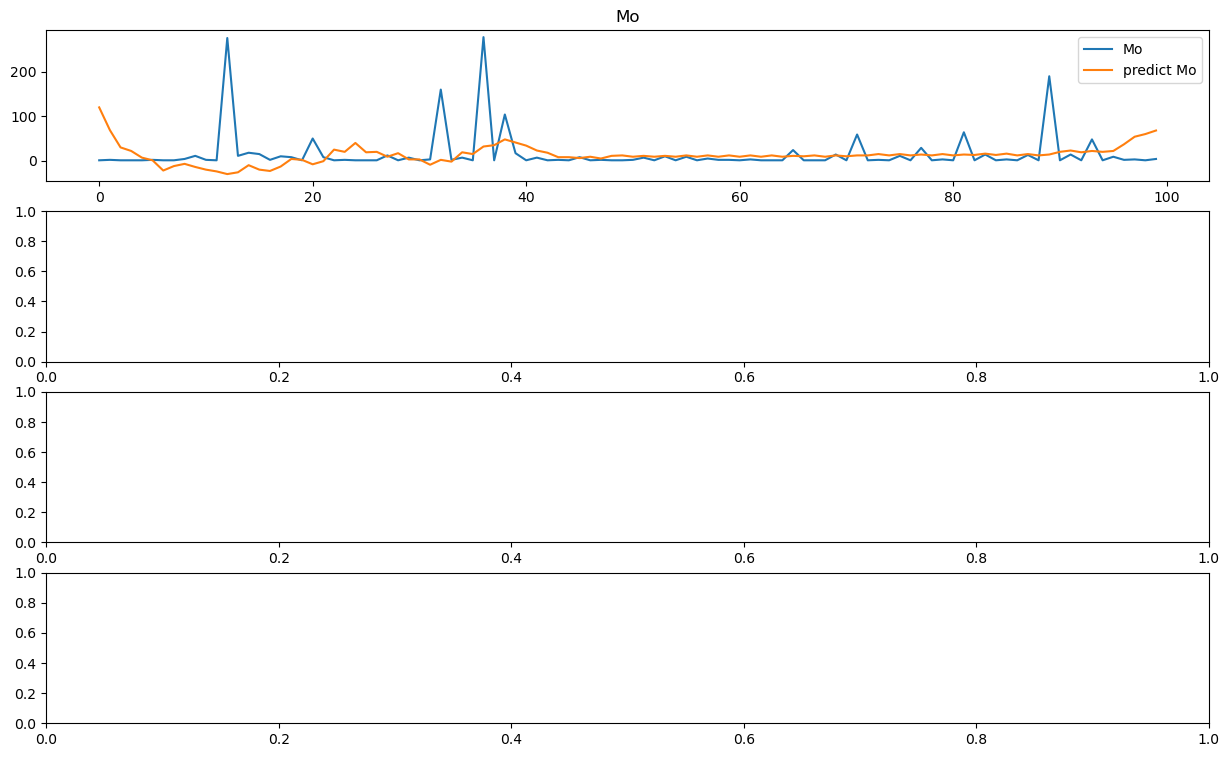

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# 生成示例数据
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.tan(x)
num = 8000
start = 0
end = 100
p_round = predictions.round()
t_round = y_test #targets.round()
p1 = p_round[start:end]
t1 = t_round[start:end]
# 创建一个包含三个子图的画布
fig, axs = plt.subplots(4, 1, figsize=(15, 9))

# 在第一个子图中绘制 y1
axs[0].plot(t1[:], label='Mo')
axs[0].plot(p1[:], label='predict Mo')
#
axs[0].set_title('Mo')
axs[0].legend(loc='upper right')

# 在第二个子图中绘制 y2
axs[1].plot(t1[:, 1], label='O')
axs[1].plot(p1[:, 1], label='predict O')
# axs[1].plot(p1[:, 1], color='blue', label='predict O')
# axs[1].plot(t1[:, 1], color='red', label='O')
axs[1].set_title('O')
axs[1].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[2].plot(t1[:, 2], label='S')
axs[2].plot(p1[:, 2], label='predict S')
axs[2].set_title('S')
axs[2].legend(loc='upper right')
# 在第三个子图中绘制 y3
# axs[3].plot(t1[:, 3], label='target')
# axs[3].plot(p1[:, 3], label='predict')
# axs[3].set_title('time')
# axs[3].legend(loc='upper right')
# 设置统一的横坐标标签
for ax in axs:
    # plt.xlim(1100, 1200)
    ax.set_xlabel('state transition')
# axs[0].set_xlim(1100, 1200)
# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
# plt.savefig('result.png')

In [140]:
t_round.shape

NameError: name 't_round' is not defined

In [151]:
dd = np.array(cy_data[0])
dd.shape

(464, 4)

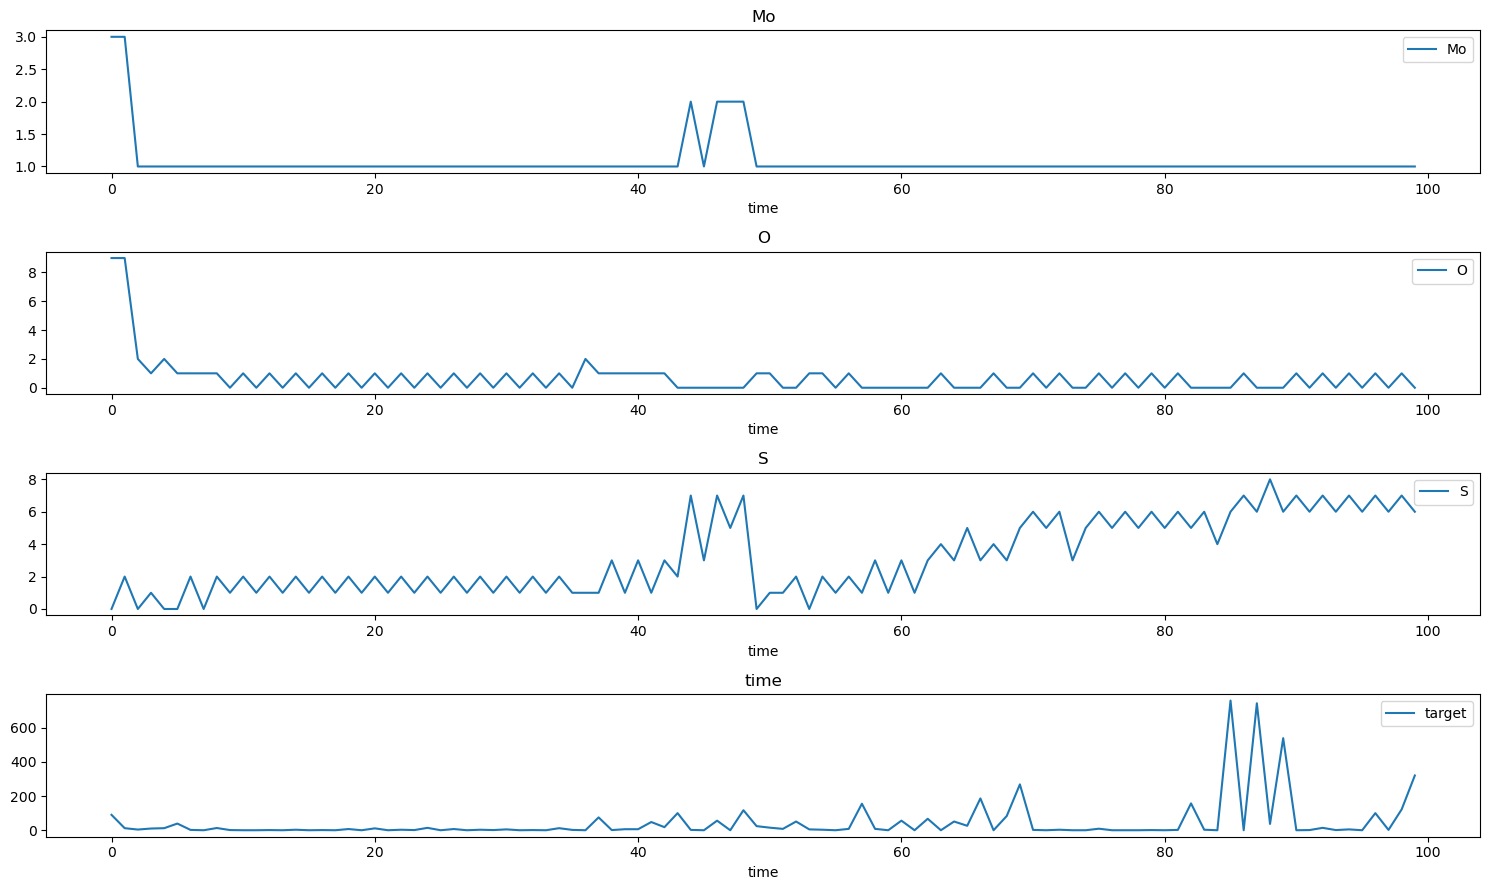

In [152]:
# 可视化cy_data
import matplotlib.pyplot as plt
import numpy as np

# 生成示例数据
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.tan(x)
num = 8000
start = 0
end = 100
# p_round = predictions.round()
t_round = dd #targets.round()
# p1 = p_round[start:end, :]
t1 = t_round[start:end, :]
# 创建一个包含三个子图的画布
fig, axs = plt.subplots(4, 1, figsize=(15, 9))

# 在第一个子图中绘制 y1
axs[0].plot(t1[:, 0], label='Mo')
# axs[0].plot(p1[:, 0], label='predict Mo')
#
axs[0].set_title('Mo')
axs[0].legend(loc='upper right')

# 在第二个子图中绘制 y2
axs[1].plot(t1[:, 1], label='O')
# axs[1].plot(p1[:, 1], label='predict O')
# axs[1].plot(p1[:, 1], color='blue', label='predict O')
# axs[1].plot(t1[:, 1], color='red', label='O')
axs[1].set_title('O')
axs[1].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[2].plot(t1[:, 2], label='S')
# axs[2].plot(p1[:, 2], label='predict S')
axs[2].set_title('S')
axs[2].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[3].plot(t1[:, 3], label='target')
# axs[3].plot(p1[:, 3], label='predict')
axs[3].set_title('time')
axs[3].legend(loc='upper right')
# 设置统一的横坐标标签
for ax in axs:
    # plt.xlim(1100, 1200)
    ax.set_xlabel('time')
# axs[0].set_xlim(1100, 1200)
# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
# plt.savefig('result.png')

In [1]:
import numpy as np
ss = np.load('../results/mul_T900_ss.npz')
ss_targets = ss['arr1']
ss_predictions = ss['arr2']

sts = np.load('../results/mul_T900_sts.npz')
sts_targets = sts['arr1']
sts_predictions = sts['arr2']

stst = np.load('../results/mul_T900_stst.npz')
stst_targets = stst['arr1']
stst_predictions = stst['arr2']

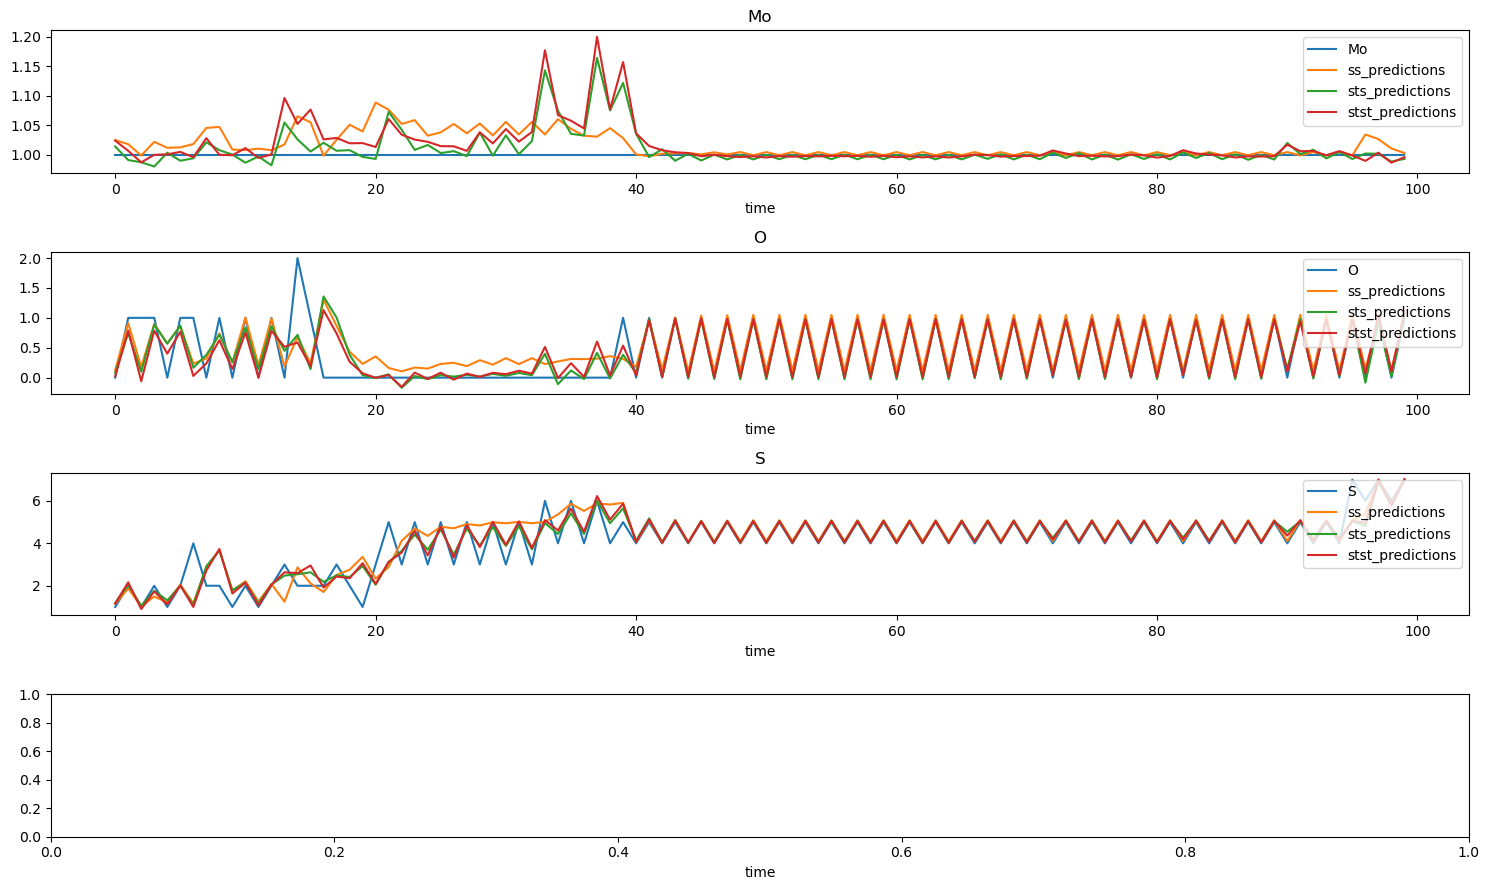

In [3]:
# 可视化cy_data
import matplotlib.pyplot as plt
import numpy as np

# 生成示例数据
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.tan(x)
num = 8000
start = 0
end = 100
# p_round = predictions.round()
t_round = stst_targets #targets.round()
# p1 = p_round[start:end, :]
t1 = t_round[start:end, :]
# 创建一个包含三个子图的画布
fig, axs = plt.subplots(4, 1, figsize=(15, 9))

# 在第一个子图中绘制 y1
axs[0].plot(t1[:, 0], label='Mo')
axs[0].plot(ss_predictions[start:end, 0], label='ss_predictions')
axs[0].plot(sts_predictions[start:end, 0], label='sts_predictions')
axs[0].plot(stst_predictions[start:end, 0], label='stst_predictions')
#
axs[0].set_title('Mo')
axs[0].legend(loc='upper right')

# 在第二个子图中绘制 y2
axs[1].plot(t1[:, 1], label='O')
axs[1].plot(ss_predictions[start:end, 1], label='ss_predictions')
axs[1].plot(sts_predictions[start:end, 1], label='sts_predictions')
axs[1].plot(stst_predictions[start:end, 1], label='stst_predictions')
# axs[1].plot(p1[:, 1], label='predict O')
# axs[1].plot(p1[:, 1], color='blue', label='predict O')
# axs[1].plot(t1[:, 1], color='red', label='O')
axs[1].set_title('O')
axs[1].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[2].plot(t1[:, 2], label='S')
axs[2].plot(ss_predictions[start:end, 2], label='ss_predictions')
axs[2].plot(sts_predictions[start:end, 2], label='sts_predictions')
axs[2].plot(stst_predictions[start:end, 2], label='stst_predictions')
# axs[2].plot(p1[:, 2], label='predict S')
axs[2].set_title('S')
axs[2].legend(loc='upper right')
# 在第三个子图中绘制 y3
# axs[3].plot(t1[:, 3], label='target')
# # axs[3].plot(p1[:, 3], label='predict')
# axs[3].set_title('time')
# axs[3].legend(loc='upper right')
# 设置统一的横坐标标签
for ax in axs:
    # plt.xlim(1100, 1200)
    ax.set_xlabel('time')
# axs[0].set_xlim(1100, 1200)
# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
# plt.savefig('result.png')